In [3]:
import os
import math
import json
import cv2

import numpy as np
import pprint as pp
import json as JSON
import pandas as pd
import pandas_gbq

from shapely.geometry import Point, Polygon
from dotenv import load_dotenv
from matplotlib import pyplot as plt

load_dotenv()

# ___MAPS IMAGES___ 

def saveImages(images_df):
    destination_table = 'osm_data.maps_images'
    pandas_gbq.to_gbq(images_df, project_id='sidhouses', destination_table=destination_table , if_exists='replace')

def loadImages():
    df = pandas_gbq.read_gbq('SELECT * FROM sidhouses.osm_data.maps_images')
    return df

# ___BUILDINGS___ 

def saveBuildings(buildings_df):
    destination_table = 'osm_data.buildings'
    buildings_df = buildings_df.drop(columns=['polygon','point'],axis=1)
    pandas_gbq.to_gbq(buildings_df, project_id='sidhouses', destination_table=destination_table , if_exists='replace')

def loadBuildings():
    df = pandas_gbq.read_gbq('SELECT * FROM sidhouses.osm_data.buildings')
    create_polygons(df)
    create_points(df)
    return df

# ___VILLAGES___ 

def saveVillages(village_df):
    destination_table = 'osm_data.villages'
    village_df = village_df.drop(columns=['polygon','point'],axis=1)
    pandas_gbq.to_gbq(village_df, project_id='sidhouses', destination_table=destination_table , if_exists='replace')

def loadVillages():
    df = pandas_gbq.read_gbq('SELECT * FROM sidhouses.osm_data.villages')
    create_polygons(df)
    create_points(df)
    return df

# --------- AUX ---------

def create_polygons(df):
  df['polygon'] = ""
  for index, row in df.iterrows():
    if (row['boundary_lon'] != '' and  row['boundary_lat'] != ''):
      lon = json.loads(row['boundary_lon'])
      lat = json.loads(row['boundary_lat'])
      df.at[index,'polygon'] = Polygon(zip(lon,lat))

def create_points(df):
  df['point'] = ""
  for index, row in df.iterrows():
    if (row['lat'] != '' and  row['lon'] != ''):
      p = Point(float(row['lon']) , float(row['lat']))
      df.at[index,'point'] = p 


def point_px_to_deg(lat, lon, image_row_ref):
    deg_per_px_lat = row_ref.iloc[0]['deg_per_px_lat']
    deg_per_px_lon = row_ref.iloc[0]['deg_per_px_lon']

    lat_deg = row_ref.iloc[0]['lat_0'] - lat * deg_per_px_lat
    lon_deg = row_ref.iloc[0]['lon_0'] + lon * deg_per_px_lon
    return lat_deg, lon_deg

def point_deg_to_px(lat, lon, image_row_ref):

    deg_per_px_lat = row_ref.iloc[0]['deg_per_px_lat']
    deg_per_px_lon = row_ref.iloc[0]['deg_per_px_lon']

    lat_px = (row_ref.iloc[0]['lat_0'] - lat) / deg_per_px_lat
    lon_px = (lon - row_ref.iloc[0]['lon_0'] ) / deg_per_px_lon

    lat_px = lat_px - 43 * math.floor(lat_px / image_row_ref.iloc[0]['input_size'])
    return lat_px, lon_px


In [4]:
# import data bases
images_df = loadImages()
# buildings_df = loadBuildings()

Downloading: 100%|██████████| 5/5 [00:00&lt;00:00, 20.58rows/s]


In [71]:
buildings_df.village.unique()

array([&#39;MONNON&#39;, &#39;BARKEDJE BARIKEDJE&#39;, &#39;BOUDAL&#39;, &#39;SANSI GANDÓ&#39;,
       &#39;BESEN GOUROU&#39;], dtype=object)

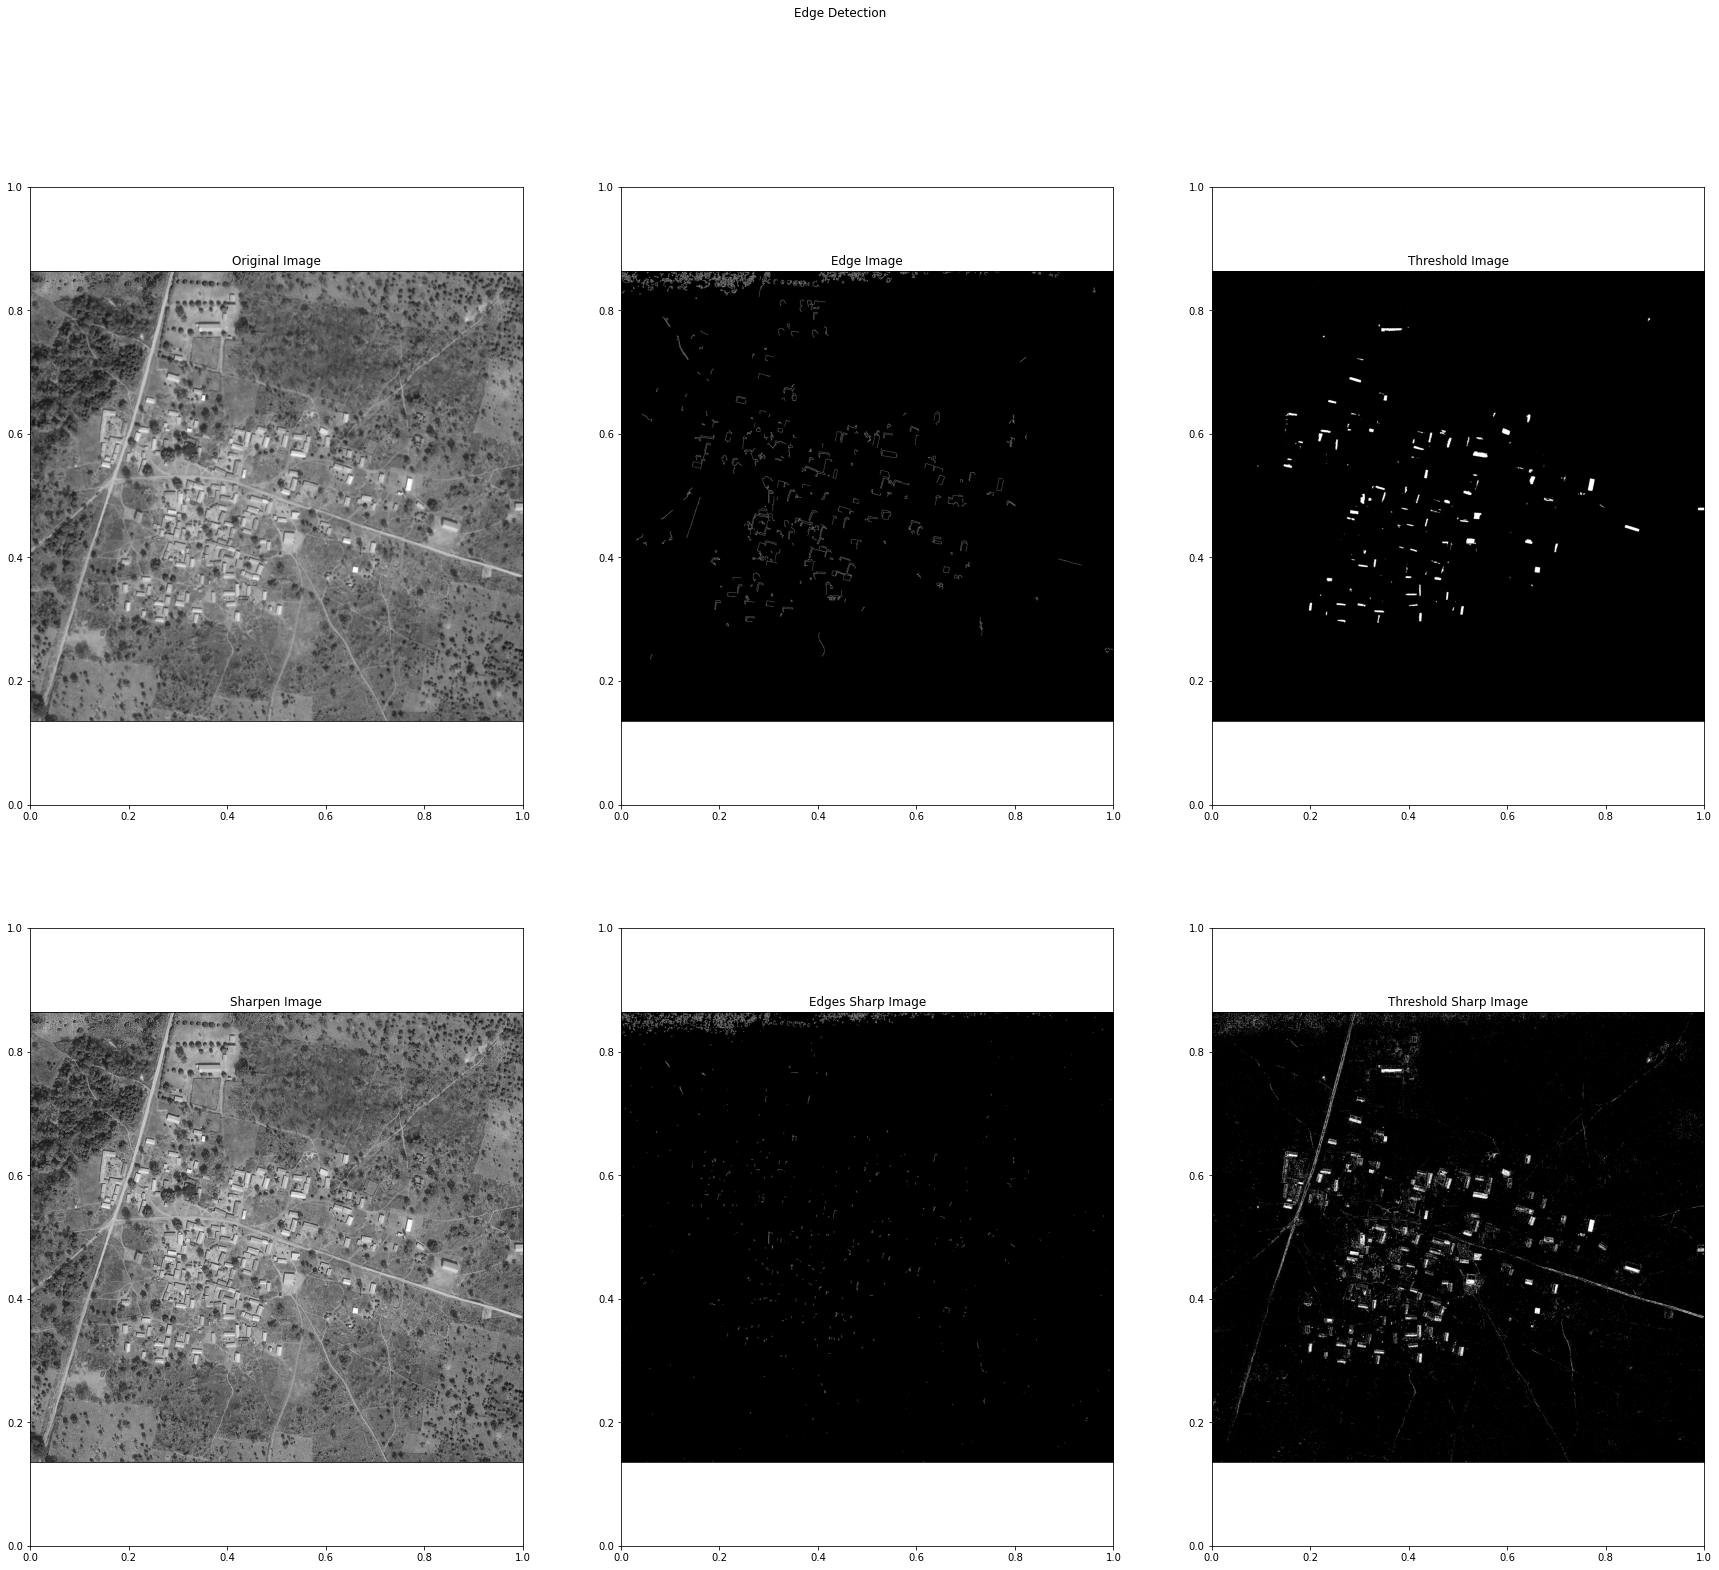

In [95]:
row_ref = images_df.loc[images_df['name'] == 'Monnon']

image_ref = './images/' + row_ref.iloc[0]['img_name']

# Main image
img = cv2.imread(image_ref,0)

# Sharpen image
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sha = cv2.filter2D(img, -1, kernel)

# Edges in main image
edges = cv2.Canny(img,90,300)

# Edges in sharp image
edges_sha = cv2.Canny(img_sha,900,500)

# threshold in main image
ret,thresh = cv2.threshold(img,200,200,0)
contours = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]

# threshold in sharp image
ret,thresh_sha = cv2.threshold(img_sha,200,200,0)
contours_sha = cv2.findContours(thresh_sha, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]



# Output dtype = cv2.CV_8U
sobelx8u = cv2.Sobel(img_sha,cv2.CV_16S,1,0,ksize=5)


"""
print(len(contours))

for contour in contours:
   cv2.drawContours(img, contour, -1, (0, 0, 0), 3)
"""

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 25))
fig.suptitle('Edge Detection')

# Add plot 
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title("Original Image")
ax1.set_xticks([])
ax1.set_yticks([])

# Add plot 
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(edges , cmap = 'gray')
ax2.set_title("Edge Image")
ax2.set_xticks([])
ax2.set_yticks([])

# Add plot 
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(thresh , cmap = 'gray')
ax3.set_title("Threshold Image")
ax3.set_xticks([])
ax3.set_yticks([])

# Add plot 
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(img_sha , cmap = 'gray')
ax4.set_title("Sharpen Image")
ax4.set_xticks([])
ax4.set_yticks([])

# Add plot 
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(edges_sha , cmap = 'gray')
ax5.set_title("Edges Sharp Image")
ax5.set_xticks([])
ax5.set_yticks([])

# Add plot 
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(thresh_sha , cmap = 'gray')
ax6.set_title("Threshold Sharp Image")
ax6.set_xticks([])
ax6.set_yticks([])

plt.show()


In [ ]:
# test coords in image

row_ref = images_df.loc[images_df['name'] == 'Monnon']

image_ref = './images/' + row_ref.iloc[0]['img_name']

img = cv2.imread(image_ref,0)
fig, ax = plt.subplots(figsize=(15, 185))

for build_row in buildings_df.iterrows():
    if build_row[1]['village'] == 'MONNON':
        lat_px, lon_px = point_deg_to_px( float(build_row[1]['lat']) , float(build_row[1]['lon']) , row_ref )

        cir = plt.Circle((lon_px+10, lat_px), 5, color='y')

        ax.add_artist(cir)


lat2_px, lon2_px = point_deg_to_px(9.84218,3.18105, row_ref )
cir2 = plt.Circle((lon2_px, lat2_px), 5, color='b')
ax.add_artist(cir2)

ax.imshow(img)